In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam,SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import models
from keras.models import Model

### let's start by listing our directories

In [2]:
data_dir=r'Crop___Disease/Corn'classes=[class_name for class_name in os.listdir(data_dir) if not class_name.startswith('.')]
classes

['Corn___Northern_Leaf_Blight',
 'Corn___Common_Rust',
 'Corn___Healthy',
 'Corn___Gray_Leaf_Spot']

### We have 4 classes to be predicted by our cnn, they are as follows:
#### 1- Corn___Northern_Leaf_Blight
#### 2- Corn___Common_Rust
#### 3- Corn___Healthy
#### 4- Corn___Gray_Leaf_Spot

### We plot one of the images we have in the dataset

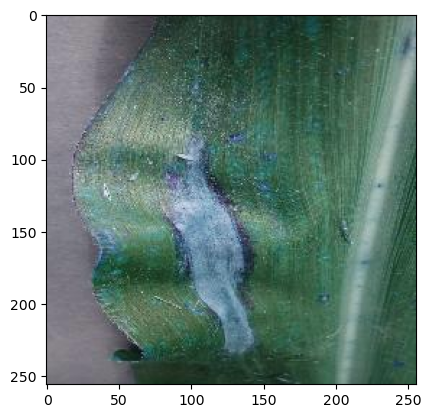

In [3]:
for category in classes:
    path=os.path.join(data_dir,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break  
    break

### Now, we pre-process our dataset to make it ready for training

In [4]:
training_data= []
def create_training_data():
    for category in classes:
        path=os.path.join(data_dir,category)
        class_num=classes.index(category)
        for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            training_data.append([img_array,class_num])
create_training_data()

In [5]:
print(f'We have {len(training_data)} images.')

We have 3852 images.


In [6]:
X=[]
y=[]
for features, labels in training_data:
    X.append(features)
    y.append(labels)
X=np.array(X)/255
y=np.array(y)

In [7]:
print(np.shape(X))

(3852, 256, 256, 3)


In [8]:
y= keras.utils.to_categorical(y, num_classes=4)

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=27)

In [10]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3274
578
3274
578


### This model is based on the VGG16 architecture, a powerful convolutional neural network pre-trained on ImageNet. 

### The model is fine-tuned to perform a multi classification task. The VGG16 base model is frozen to retain its pre-trained weights and features. Additional layers, including convolutional, max-pooling, and dropout layers, are added to extract and enhance features from the input images. The final layers consist of a flattening operation followed by a dense layer with softmax activation, mapping the extracted features to class probabilities. The model is designed for image classification tasks with an input shape of (256, 256, 3) and outputs probabilities for four classes. 

### The summary provides insights into the model's architecture, detailing the layers, output shapes, and the total number of parameters.

In [11]:
base_model = tf.keras.applications.VGG16(
    input_shape=(256,256,3), include_top=False,
    weights='imagenet', pooling=None,
    )

model = Sequential()
base_model.trainable=False
model.add(base_model)

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=4, activation='softmax')) 
model.summary()

2023-12-15 18:28:34.238478: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-15 18:28:34.249488: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-15 18:28:34.249511: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-15 18:28:34.258625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-15 18:28:34.265750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         524544    
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 256)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                   

### The ImageDataGenerator is configured for data augmentation, incorporating horizontal and vertical flips, shearing, zooming, and random shifts in width, height, and rotation. The 'nearest' fill mode is applied to handle transformations.







In [12]:
train_datagen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                         shear_range = 0.2,zoom_range = 0.2,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                        rotation_range=40,fill_mode='nearest')

### The model is compiled using the Adam optimizer with a learning rate of 0.001, categorical crossentropy loss, and accuracy metrics. It's then trained on augmented data using the specified ImageDataGenerator, with 20 epochs and batch size of 64, considering training and validation sets.

In [13]:
opt= Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history=model.fit(x=train_datagen.flow(X_train,y_train,seed=27,
        shuffle=False),  
    steps_per_epoch=X_train.shape[0] // 64,
    validation_data=(X_test,y_test),
                  epochs=20,
    validation_steps=len(X_test)//64)

Epoch 1/20


2023-12-15 18:29:15.000268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 81s 2s/step - loss: 0.8304 - accuracy: 0.6702 - val_loss: 0.3908 - val_accuracy: 0.8426
Epoch 2/20
51/51 [==============================] - 78s 2s/step - loss: 0.4012 - accuracy: 0.8346 - val_loss: 0.2594 - val_accuracy: 0.9100
Epoch 3/20
51/51 [==============================] - 74s 1s/step - loss: 0.3323 - accuracy: 0.8529 - val_loss: 0.2128 - val_accuracy: 0.9343
Epoch 4/20
51/51 [==============================] - 75s 1s/step - loss: 0.2494 - accuracy: 0.8964 - val_loss: 0.2400 - val_accuracy: 0.8997
Epoch 5/20
51/51 [==============================] - 83s 2s/step - loss: 0.2424 - accuracy: 0.9020 - val_loss: 0.1800 - val_accuracy: 0.9256
Epoch 6/20
51/51 [==============================] - 79s 2s/step - loss: 0.2053 - accuracy: 0.9168 - val_loss: 0.1581 - val_accuracy: 0.9377
Epoch 7/20
51/51 [==============================] - 86s 2s/step - loss: 0.2010 - accuracy: 0.9191 - val_loss: 0.2368 - val_accuracy: 0.8910
Epoch 8/20
51/51 [=============

### In the last epoch (Epoch 20), the model achieved a training loss of 0.1263 and training accuracy of 94.84%. During validation, the model attained a validation loss of 0.1490 and a validation accuracy of 94.64%. These metrics suggest that the model performs well, exhibiting robustness and generalization to unseen data.

In [15]:
model.save('/Users/mohsenboughriou/Downloads/archive/corn_diseases classification_model')

INFO:tensorflow:Assets written to: /Users/mohsenboughriou/Downloads/archive/corn_diseases classification_model/assets


INFO:tensorflow:Assets written to: /Users/mohsenboughriou/Downloads/archive/corn_diseases classification_model/assets


## Enjoy your model :) 